# Clustering Crypto

In [42]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

### Fetching Cryptocurrency Data

In [43]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"
response = requests.get(url).json()

In [44]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [45]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")
# Create a DataFrame
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [46]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [47]:
# Keep only cryptocurrencies that are trading
df = df[df.IsTrading == True]
df2 = df
df.IsTrading.value_counts()

True    1144
Name: IsTrading, dtype: int64

In [48]:
# Keep only cryptocurrencies with a working algorithm
df.Algorithm.value_counts().head()

Scrypt     394
X11        182
SHA-256    121
X13         54
PoS         42
Name: Algorithm, dtype: int64

In [49]:
# Remove the "IsTrading" column
df.drop(columns='IsTrading', inplace=True)
df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
1,365Coin,X11,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,PoW,NaN,611000
4,808,SHA-256,PoW/PoS,0.000000e+00,0


In [50]:
# Remove rows with at least 1 null value
df.dropna(inplace=True)
df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
4,808,SHA-256,PoW/PoS,0.000000e+00,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [51]:
# Remove rows with cryptocurrencies having no coins mined
df = df[df.TotalCoinsMined > 0]
df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
8,Ethereum,Ethash,PoW,1.076842e+08,0


In [52]:
# Drop rows where there are 'N/A' text values
df = df[df[:] != "N/A"]

In [53]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
df_CoinName = df.iloc[:,0].to_frame()
df_CoinName.head()

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
8,Ethereum


In [54]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
df.drop(columns=['CoinName'], inplace=True)
df.head(1)

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,41.999954,42


In [55]:
# Create dummy variables for text features
df = pd.get_dummies(df, columns=['Algorithm','ProofType'])
df.head(3)

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [56]:
# Standardize data
df_scaled = StandardScaler().fit_transform(df)
print(df_scaled[0:1])

[[-0.11710817 -0.1528703  -0.0433963  -0.0433963  -0.0433963  -0.06142951
  -0.07530656 -0.0433963  -0.06142951 -0.06142951 -0.0433963  -0.0433963
  -0.19245009 -0.06142951 -0.09740465 -0.0433963  -0.11547005 -0.07530656
  -0.0433963  -0.0433963  -0.15191091 -0.0433963  -0.13118084 -0.0433963
  -0.0433963  -0.08703883 -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.06142951 -0.0433963  -0.08703883 -0.08703883 -0.08703883 -0.0433963
  -0.13118084 -0.13840913 -0.13840913 -0.0433963  -0.06142951 -0.0433963
  -0.07530656 -0.18168574 -0.0433963  -0.0433963  -0.0433963  -0.07530656
  -0.15826614 -0.31491833 -0.0433963  -0.08703883 -0.07530656 -0.06142951
   1.38675049 -0.0433963  -0.0433963  -0.06142951 -0.0433963  -0.0433963
  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.39879994 -0.0433963  -0.18168574 -0.0433963  -0.08703883 -0.08703883
  -0.10680283 -0.0433963  -0.13118084 -0.0433963  -0.0433963  -0.0433963
  -0.0433963  -0.07530656 -0.43911856 -0.04339

### Reducing Dimensions Using PCA

In [57]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
df_scaled_transformed = pca.fit_transform(df_scaled)

In [58]:
# Create a DataFrame with the principal components data
df_pca = pd.DataFrame(
    data = df_scaled_transformed, columns = ["PC 1", "PC 2", "PC 3"]
)

### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [59]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(df_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [60]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=1)
# Fit the model
model.fit(df_pca)
# Predict clusters
pedictions = model.predict(df_pca)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
df_pca["Class"] = model.labels_
df_pca["Class"].value_counts()

0    287
1    239
3      5
2      1
Name: Class, dtype: int64

### Visualizing Results

#### 3D-Scatter with Clusters

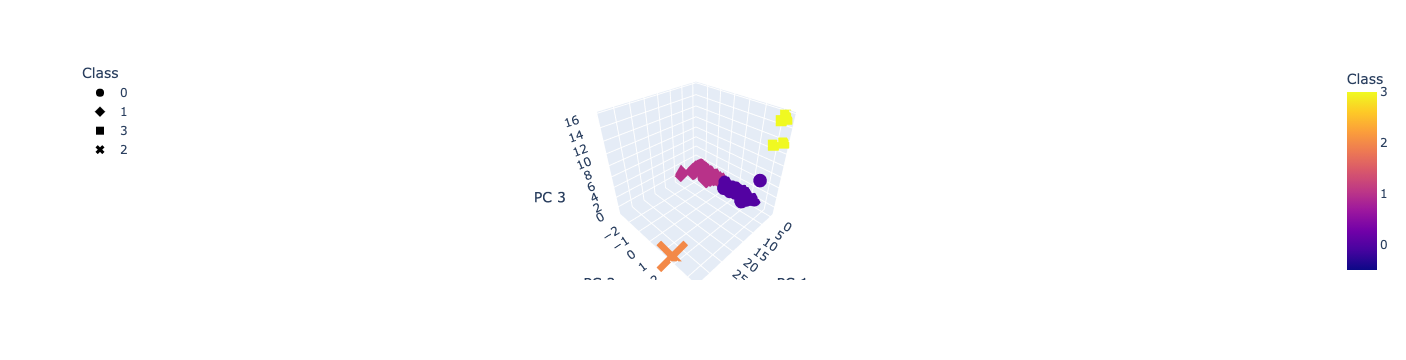

In [61]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    df_pca,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    width=1000,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [62]:
df2.dropna(inplace=True)
df2 = df2[df2[:] != "N/A"]
df2 = df2[df2.TotalCoinsMined > 0]
df2.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
8,Ethereum,Ethash,PoW,1.076842e+08,0


In [63]:
df2['TotalCoinSupply'] = df2['TotalCoinSupply'].astype(float)
df2.dtypes

CoinName            object
Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object

#### Table of Tradable Cryptocurrencies

In [64]:
# Table with tradable cryptos
tradable_crpto = df2.loc[:,["CoinName","TotalCoinsMined","TotalCoinSupply"]]
tradable_crpto.head()

,CoinName,TotalCoinsMined,TotalCoinSupply
0,42 Coin,4.199995e+01,4.200000e+01
2,404Coin,1.055185e+09,5.320000e+08
5,EliteCoin,2.927942e+10,3.141593e+11
7,Bitcoin,1.792718e+07,2.100000e+07
8,Ethereum,1.076842e+08,0.000000e+00


In [66]:
# Print the total number of tradable cryptocurrencies
index = tradable_crpto.index
tradable_crypto = len(index)
tradable_crypto

532

In [68]:
tradable_crpto = tradable_crpto.loc[:,["TotalCoinsMined","TotalCoinSupply"]]
tradable_crpto.head()

,TotalCoinsMined,TotalCoinSupply
0,4.199995e+01,4.200000e+01
2,1.055185e+09,5.320000e+08
5,2.927942e+10,3.141593e+11
7,1.792718e+07,2.100000e+07
8,1.076842e+08,0.000000e+00


#### Scatter Plot with Tradable Cryptocurrencies

In [69]:
# Scale data to create the scatter plot
tradable_crpto_scaled = StandardScaler().fit_transform(tradable_crpto)
df_tradable_crpto = pd.DataFrame(data=tradable_crpto_scaled, columns=["TotalCoinsMined","TotalCoinSupply"])
df_tradable_crpto["CoinName"] = df2["CoinName"]
df_tradable_crpto.head()

,TotalCoinsMined,TotalCoinSupply,CoinName
0,-0.117108,-0.152870,42 Coin
1,-0.093970,-0.145009,NaN
2,0.524946,4.489424,404Coin
3,-0.116715,-0.152560,NaN
4,-0.114747,-0.152870,NaN


In [72]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
df_tradable_crpto.hvplot.scatter(
    x="TotalCoinsMined",
    y="TotalCoinSupply",
    hover_cols=["CoinName"],
    by="CoinName",
)

:NdOverlay   [CoinName]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)